To train the Semantic Segmentation algorithm on Amazon SageMaker, we need to setup and authenticate the use of AWS services. To begin with, we need an AWS account role with SageMaker access. This role that is used to give SageMaker access to your data in S3 can automatically be obtained from the role used to start the notebook.

Create ground truth labeling job workflow 
https://aws.amazon.com/getting-started/hands-on/build-training-datasets-amazon-sagemaker-ground-truth/
https://aws.amazon.com/blogs/aws/amazon-sagemaker-ground-truth-build-highly-accurate-datasets-and-reduce-labeling-costs-by-up-to-70/
    

https://aws.amazon.com/blogs/machine-learning/easily-train-models-using-datasets-labeled-by-amazon-sagemaker-ground-truth/

In [1]:
import sagemaker
from sagemaker import get_execution_role
 
role = get_execution_role()
print(role)
sess = sagemaker.Session()

arn:aws:iam::773208840593:role/my_AmazonSageMakerFullAccess


we need the Amazon SageMaker Semantic Segmentaion docker image, which is static and need not be changed.

In [2]:
from sagemaker.amazon.amazon_estimator import get_image_uri
training_image = get_image_uri(sess.boto_region_name, 'semantic-segmentation', repo_version="latest")
print (training_image)

813361260812.dkr.ecr.eu-central-1.amazonaws.com/semantic-segmentation:latest


Using sagemaker ground truth output to create a sagemaker training job

https://aws.amazon.com/blogs/machine-learning/easily-train-models-using-datasets-labeled-by-amazon-sagemaker-ground-truth/

Next we need to setup an output location at S3, where the model artifact will be dumped. These artifacts are also the output of the algorithm's traning job. Let us use another channel in the same S3 bucket for this purpose.


In [3]:
bucket = 'raz-sagemaker' 
prefix = 'semantic-segmentation-demo'
print(bucket)
s3_output_location = 's3://{}/{}/output'.format(bucket, prefix)
print(s3_output_location)

raz-sagemaker
s3://raz-sagemaker/semantic-segmentation-demo/output


Now that we are done with all the setup that is needed, we are ready to train our segmentation algorithm. Let us also use a nice-and-fast GPU instance (ml.p3.2xlarge) to train.

In [4]:
ss_model = sagemaker.estimator.Estimator(training_image,
                                         role, 
                                         train_instance_count=1, 
                                         train_instance_type='ml.p3.2xlarge',
                                         train_volume_size = 50,
                                         train_max_run = 360000,
                                         input_mode = 'Pipe',
                                         output_path=s3_output_location,
                                         sagemaker_session=sess)

In [15]:
import numpy as np
import boto3
import tempfile

bucket = 'raz-sagemaker'
prefix = 'raz-sagemakerjob/manifests/output/output.manifest'

s3_train_data = 's3://{}/{}'.format(bucket, prefix)
s3_validation_data = 's3://{}/{}'.format(bucket,prefix)
print(s3_train_data)

s3 = boto3.resource('s3', region_name='eu-central-1')
bucket = s3.Bucket('raz-sagemaker')
object = bucket.Object('raz-sagemakerjob/manifests/output/output.manifest')
tmp = tempfile.NamedTemporaryFile()
print(object)

with open(tmp.name, 'wb') as f:
    object.download_fileobj(f)
    
with open(tmp.name) as f:
    num_training_samples = sum(1 for line in f)
    print (num_training_samples)

    
train_data = sagemaker.session.s3_input(s3_train_data, distribution='FullyReplicated', content_type='image/jpeg', s3_data_type='AugmentedManifestFile', attribute_names=['source-ref', 'raz-sagemakerjob-ref'])
validation_data = sagemaker.session.s3_input(s3_validation_data, distribution='FullyReplicated', content_type='image/jpeg', s3_data_type='AugmentedManifestFile', attribute_names=['source-ref', 'raz-sagemakerjob-ref'])




s3://raz-sagemaker/raz-sagemakerjob/manifests/output/output.manifest
s3.Object(bucket_name='raz-sagemaker', key='raz-sagemakerjob/manifests/output/output.manifest')
84


The semantic segmentation algorithm at its core has two compoenents.

An encoder or backbone network,
A decoder or algorithm network.
The encoder or backbone network is typically a regular convolutional neural network that may or maynot have had their layers pre-trained on an alternate task such as the classification task of ImageNet images. The Amazon SageMaker Semantic Segmentation algorithm comes with two choices of pre-trained or to be trained-from-scratch backbone networks (ResNets 50 or 101).

The decoder is a network that picks up the outputs of one or many layers from the backbone and reconstructs the segmentation mask from it. Amazon SageMaker Semantic Segmentation algorithm comes with a choice of the Fully-convolutional network (FCN) or the Pyramid scene parsing (PSP) network.

The algorithm also has ample options for hyperparameters that help configure the training job. The next step in our training, is to setup these networks and hyperparameters along with data channels for training the model. Consider the following example definition of hyperparameters. See the SageMaker Semantic Segmentation documentation for more details on the hyperparameters.

One of the hyperparameters here for instance is the epochs

{'DataSource': {'S3DataSource': {'S3DataType': 'AugmentedManifestFile',
   'S3Uri': 's3://raz-sagemaker/raz-sagemakerjob/manifests/output/output.manifest',
   'S3DataDistributionType': 'FullyReplicated',
   'AttributeNames': ['source-ref', 'raz-sagemakerjob-ref']}},
 'ContentType': 'image/jpeg'}

In [8]:
# Setup hyperparameters 
ss_model.set_hyperparameters(backbone='resnet-50', # This is the encoder. Other option is resnet-50
                             algorithm='fcn', # This is the decoder. Other option is 'psp' and 'deeplab'                             
                             use_pretrained_model='True', # Use the pre-trained model.
                             crop_size=240, # Size of image random crop.                             
                             num_classes=2, # Pascal has 21 classes. This is a mandatory parameter.
                             epochs=10, # Number of epochs to run.
                             learning_rate=0.0001,                             
                             optimizer='rmsprop', # Other options include 'adam', 'rmsprop', 'nag', 'adagrad'.
                             lr_scheduler='poly', # Other options include 'cosine' and 'step'.                           
                             mini_batch_size=16, # Setup some mini batch size.
                             validation_mini_batch_size=16,
                             early_stopping=True, # Turn on early stopping. If OFF, other early stopping parameters are ignored.
                             early_stopping_patience=2, # Tolerate these many epochs if the mIoU doens't increase.
                             early_stopping_min_epochs=10, # No matter what, run these many number of epochs.                             
                             num_training_samples=num_training_samples) # This is a mandatory parameter, 1464 in this case.

In [9]:
data_channels = {'train': train_data, 'validation': validation_data}
ss_model.fit(inputs=data_channels, logs=True)

ResourceLimitExceeded: An error occurred (ResourceLimitExceeded) when calling the CreateTrainingJob operation: The account-level service limit 'ml.p3.2xlarge for training job usage' is 0 Instances, with current utilization of 0 Instances and a request delta of 1 Instances. Please contact AWS support to request an increase for this limit.

# Hosting
Once the training is done, we can deploy the trained model as an Amazon SageMaker hosted endpoint.  we choose to host the model on the less expensive cpu instance, ml.c5.xlarge.

In [10]:
ss_predictor = ss_model.deploy(initial_instance_count=1, instance_type='ml.c4.xlarge')

ValueError: Estimator is not associated with a training job

# Display image
Let us desplay an image from the traing bucket and check out the inference

s3.Object(bucket_name='raz-sagemaker', key='ultrasound-jpeg/09-41-06_1.jpg')


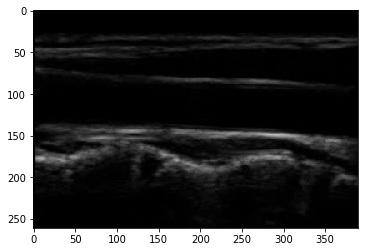

In [12]:
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
from PIL import Image


import numpy as np
import boto3
import tempfile
 
s3 = boto3.resource('s3', region_name='eu-central-1')
bucket = s3.Bucket('raz-sagemaker')
object = bucket.Object('ultrasound-jpeg/09-41-06_1.jpg')
tmp = tempfile.NamedTemporaryFile()
filename = tmp.name
print(object)

with open(filename, 'wb') as f:
    object.download_fileobj(f)
    img=mpimg.imread(filename)
    plt.imshow(img)


NameError: name 'ss_predictor' is not defined

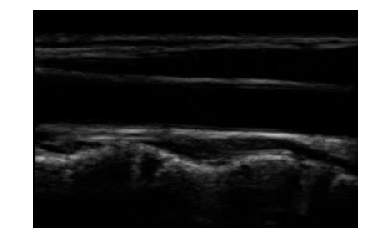

In [14]:

import matplotlib.pyplot as plt

import PIL

# resize image size for inference
im = PIL.Image.open(filename)
im.thumbnail([800,600],PIL.Image.ANTIALIAS)
im.save(filename, "JPEG")


plt.imshow(im)
plt.axis('off')
with open(filename, 'rb') as image:
    img = image.read()
    img = bytearray(img)
    
    
ss_predictor.content_type = 'image/jpeg'
ss_predictor.accept = 'image/png'
return_img = ss_predictor.predict(img)